# Winning Jeopardy with Data: Insights from 200,000 Questions

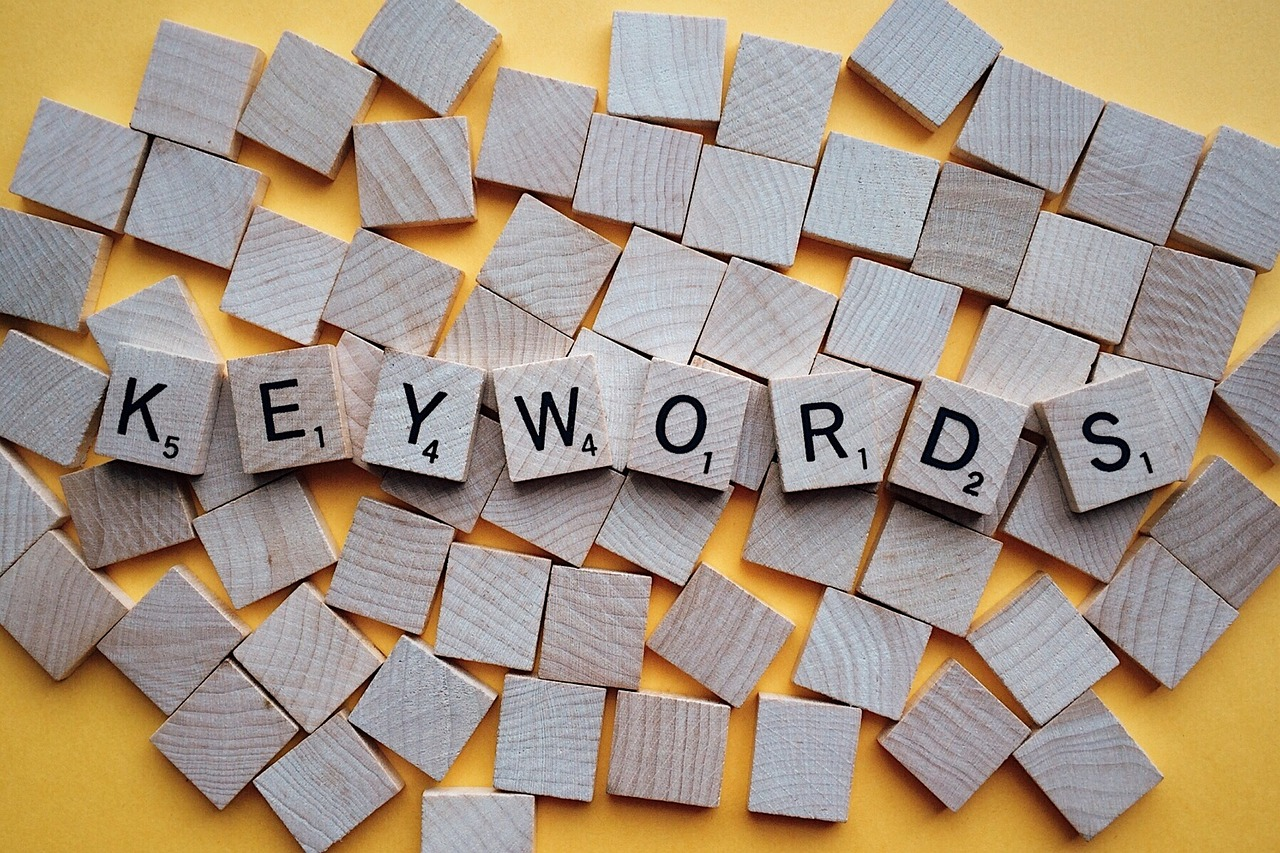

## Introduction  

This project analyzes the full Jeopardy dataset to uncover patterns that might provide a competitive edge in the game. The main objective is to investigate whether specific words in the question text can serve as subtle hints for the correct answers more often than expected by chance.  

To explore this, we cleaned and preprocessed the dataset, then applied statistical tests like the chi-squared test to compare word frequency distributions between the training and test sets. The focus was on identifying words that frequently appear alongside particular answers, potentially revealing useful patterns for players.  

The analysis identified several statistically significant terms—such as *art*, *shows*, and *baseball*—that appeared more often in questions related to their corresponding answers. These findings suggest that recognizing such patterns could help improve a player’s guessing accuracy, especially when similar categories reappear in the game.  

## Table of Content
---
1. [Loading and Exploring the Jeopardy Dataset](#Loading-and-Exploring-the-Jeopardy-Dataset)  
2. [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)  
3. [Answer-Question Word Overlap](#Answer-Question-Word-Overlap)  
4. [Question Reuse in Jeopardy](#Question-Reuse-in-Jeopardy)  
5. [Word Distribution in Jeopardy Questions](#Word-Distribution-in-Jeopardy-Questions)  
6. [Conclusion](#Conclusion)  

## Loading and Exploring the Jeopardy Dataset

In [7]:
import pandas as pd

# Load the JSON file into a DataFrame
raw_data = pd.read_json("JEOPARDY_QUESTIONS1.json")

def explore(df):
    '''
    Function to explore datasets:
    - Display information about the DataFrame
    - Show the first few rows
    - Show the null values for each column
    '''
    print('Data Overview:\n', '='*122, sep='')
    print(df.info())  # Displays the structure of the DataFrame: column types, counts, and memory usage.
    
    print('\nFirst few rows of the dataset:\n', '='*122, sep='')
    display(df.head(10))  # Display 10 rows for a quick glimpse of the dataset structure and content.
    
    print('\nNull values:\n', '='*122, sep='')
    print(df.isnull().sum())  # Counts missing values in each column to assess data quality.
         
# Call the explore function to perform initial data inspection.
explore(raw_data)

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   category     216930 non-null  object
 1   air_date     216930 non-null  object
 2   question     216930 non-null  object
 3   value        213296 non-null  object
 4   answer       216930 non-null  object
 5   round        216930 non-null  object
 6   show_number  216930 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 11.6+ MB
None

First few rows of the dataset:


,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680
5,3-LETTER WORDS,2004-12-31,"'In the title of an Aesop fable, this insect s...",$200,the ant,Jeopardy!,4680
6,HISTORY,2004-12-31,'Built in 312 B.C. to link Rome & the South of...,$400,the Appian Way,Jeopardy!,4680
7,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 8: 30 steals for the Birmingham Barons; 2...,$400,Michael Jordan,Jeopardy!,4680
8,EVERYBODY TALKS ABOUT IT...,2004-12-31,"'In the winter of 1971-72, a record 1,122 inch...",$400,Washington,Jeopardy!,4680
9,THE COMPANY LINE,2004-12-31,'This housewares store was named for the packa...,$400,Crate & Barrel,Jeopardy!,4680



Null values:
category          0
air_date          0
question          0
value          3634
answer            0
round             0
show_number       0
dtype: int64


## Data Cleaning and Preprocessing

In [9]:
import janitor

# Clean column names
jeopardy_df = raw_data.clean_names(strip_underscores=True)

# Convert 'air_date' to datetime format
jeopardy_df["air_date"] = pd.to_datetime(jeopardy_df["air_date"])

# Rename 'value' to 'value_usd' and clean its values
jeopardy_df = jeopardy_df.rename(columns={"value": "value_usd"})
jeopardy_df["value_usd"] = (
    jeopardy_df["value_usd"]
    .str.replace("$", "", regex=False)  # Remove dollar sign
    .str.replace(",", "", regex=False)  # Remove commas
    .replace("None", None)  # Handle missing values
    .astype("float")  # Convert to float first
    .fillna(0)  # Replace NaN values with 0
    .astype("Int64")  # Convert to integer (allows nullable Int64)
)

# Display the updates

# Display updated column names
print('Updated column names:\n', '='*22, '\n', jeopardy_df.columns, sep='')

# Display data types after conversion
print('\nUpdated data types:\n', '='*22, '\n', jeopardy_df.dtypes, sep='')

Updated column names:
Index(['category', 'air_date', 'question', 'value_usd', 'answer', 'round',
       'show_number'],
      dtype='object')

Updated data types:
category               object
air_date       datetime64[ns]
question               object
value_usd               Int64
answer                 object
round                  object
show_number             int64
dtype: object


In [10]:
jeopardy_df.head()

,category,air_date,question,value_usd,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200,John Adams,Jeopardy!,4680


In [11]:
# Function to normalize text
def normalize_text_column(series):
    """Takes a Pandas Series and normalizes text by:
       - Converting to lowercase
       - Replacing non-word characters with spaces
    """
    return series.str.replace(r'\W', ' ', regex=True).str.lower()

# Apply normalization to the Question and Answer columns
jeopardy_df["clean_question"] = normalize_text_column(jeopardy_df["question"])
jeopardy_df["clean_answer"] = normalize_text_column(jeopardy_df["answer"])

# Display the first few rows to verify
print(jeopardy_df['clean_question'].head())
print(jeopardy_df['clean_answer'].head())

0     for the last 8 years of his life  galileo was...
1     no  2  1912 olympian  football star at carlis...
2     the city of yuma in this state has a record a...
3     in 1963  live on  the art linkletter show   t...
4     signer of the dec  of indep   framer of the c...
Name: clean_question, dtype: object
0     copernicus
1     jim thorpe
2        arizona
3    mcdonald  s
4     john adams
Name: clean_answer, dtype: object


## Data Cleaning & Preprocessing Steps

---

### 1. Cleaning Column Names  
The dataset contained leading spaces in some column names. To standardize them, we used the `clean_names()` method from the `janitor` library, which:  
- Converted column names to **lowercase**.  
- Removed **leading/trailing spaces**.  
- Replaced spaces with **underscores**.  
- Ensured names **did not start with an underscore**.  

---

### 2. Converting Data Types  

#### **Air Date Column**  
- Originally stored as a **string**.  
- Converted to **datetime** format for easier time-based analysis.  

#### **Value Column (`value_usd`)**  
- Renamed from `value` to `value_usd` for clarity.  
- Removed **`$` symbols** and **commas**.  
- Converted from **string** to **integer** (`Int64`).  
- Replaced missing values (`<NA>`) with `0` to avoid issues in calculations.  

---

### 3. Normalizing Text Data  
To ensure consistency in text-based analysis, we normalized the **Question** and **Answer** columns by:  
- Converting all text to **lowercase**.  
- Removing **non-word characters** (punctuation, special symbols, etc.).  
- Storing the cleaned versions in new columns: **`clean_question`** and **`clean_answer`**.  

---

### Final Notes  
These preprocessing steps ensure that the dataset is well-structured and ready for deeper analysis, such as identifying patterns in Jeopardy questions.  

## Filtering Non-informative Words 

In [14]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Ensure stopwords are available
# nltk.download("stopwords") - execute the first time only
stop_words = set(stopwords.words("english"))

# Compute word frequency in all questions
all_words = " ".join(jeopardy_df["clean_question"]).split()
word_counts = Counter(all_words)

# Find words occurring in more than 5% of questions
threshold = 0.05 * len(jeopardy_df)
common_words = {word for word, count in word_counts.items() if count > threshold}

# Final set of words to remove (stopwords + overly common words)
words_to_remove = stop_words | common_words

## Filtering Non-Informative Words in Jeopardy Questions  

To enhance our analysis, we refine the dataset by removing non-informative words using natural language processing (NLP) techniques rather than relying on arbitrary length-based filters.  

---

### Approach  

1. **Removing Standard Stopwords**  
   - We use the `stopwords` list from the Natural Language Toolkit (NLTK) to filter out common English words like *the*, *and*, *is*, etc.  

2. **Eliminating Overly Frequent Words**  
   - We compute word frequency across all questions using the `Counter` class.  
   - Any word appearing in more than **5% of all questions** is considered too common and removed.  

3. **Creating a Comprehensive Filter List**  
   - We combine standard stopwords with our computed list of frequent words.  
   - This ensures only meaningful words remain for further analysis.  

---

### Outcome  

By applying this filtering strategy, we retain only the most informative words, improving the quality of our analysis and ensuring a more focused approach to studying Jeopardy questions.  

## Answer-Question Word Overlap

In [17]:
# Function to calculate word overlap between answer and question
def answer_in_question(row):
    split_answer = set(row["clean_answer"].split()) - {"the"}
    split_question = set(row["clean_question"].split())
    
    if not split_answer:
        return 0  # Avoid division by zero
    
    match_count = len(split_answer & split_question)  # Set intersection for efficiency
    return match_count / len(split_answer)

# Apply the function to each row
jeopardy_df["answer_in_question"] = jeopardy_df.apply(answer_in_question, axis=1)
answer_in_question_mean = jeopardy_df["answer_in_question"].mean()
print("Mean of answer_in_question:", answer_in_question_mean)

Mean of answer_in_question: 0.06073353229966505


## Understanding Answer-Question Word Overlap  

The average value of the `answer_in_question` column is **0.0607**, meaning that, on average, only **6.1%** of the words in an answer also appear in the corresponding question.  

---

### Key Insights for Studying Strategy:  
- **Low direct word overlap**: Jeopardy answers **rarely** appear verbatim in the questions.  
- **Memorization alone isn’t enough**: Simply recalling common answers is not as effective as understanding **how** questions are phrased.  
- **Focus on patterns and connections**: Studying **synonyms, related terms, and conceptual links** between questions and answers may yield better results.  
- **Practice with past questions**: Identifying recurring themes and phrasing patterns can enhance recall and improve response accuracy.  

By shifting from pure memorization to recognizing language patterns and conceptual relationships, we can develop a more effective Jeopardy study strategy.  

## Question Reuse in Jeopardy

In [20]:
# Initialize empty list and set
question_overlap = []
terms_used = set()

# Sort by air date
jeopardy_df = jeopardy_df.sort_values("air_date", ascending=True)

# Iterate through each row
for _, row in jeopardy_df.iterrows():
    split_question = set(row["clean_question"].split()) - words_to_remove  # Remove stopwords and common words
    
    match_count = len(split_question & terms_used)  # Count overlapping words
    
    terms_used.update(split_question)  # Add new words to terms_used
    
    question_overlap.append(match_count / len(split_question) if split_question else 0)

# Assign results to the DataFrame
jeopardy_df["question_overlap"] = question_overlap
question_overlap_mean = jeopardy_df["question_overlap"].mean()
print("Mean of question_overlap:", question_overlap_mean)

Mean of question_overlap: 0.944935790594037


## Investigating Question Reuse in Jeopardy  

The average **question_overlap** is approximately **0.9449**, meaning that nearly **95% of the significant words in a new Jeopardy question have appeared in previous questions**.  

---

### Key Insights:  

- **Frequent Term Reuse**: Many Jeopardy questions include words that have appeared in past questions, making familiarity with Jeopardy’s vocabulary a useful study strategy.  
- **Recurring Topics**: Certain subjects and themes tend to resurface, even if the phrasing changes.  
- **Effective Study Approach**: Focusing on commonly used terms, historical figures, scientific concepts, and frequently appearing topics can be beneficial.  
- **Pattern Recognition**: Since question wording often overlaps, practicing with past questions can help in identifying how similar topics are framed in different contexts.  

---

### Summary  

The high **question_overlap** score indicates that Jeopardy regularly recycles key terms across episodes. Reviewing past questions and familiarizing yourself with commonly used words could provide a significant advantage in predicting and answering future questions.  

## Word Distribution in Jeopardy Questions

In [23]:
import numpy as np
import random
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Identify High-Frequency Words
word_counts = Counter(" ".join(jeopardy_df["clean_question"]).split())
threshold = 50  # Minimum occurrences to be considered
frequent_terms = {word for word, count in word_counts.items() if count >= threshold}

# Compute High/Low Value Classification
jeopardy_df["high_value"] = (jeopardy_df["value_usd"] > 800).astype(int)

# Efficiently Compute Word Frequencies in High/Low Value Questions
def count_word_occurrences(word):
    high_count = np.sum(jeopardy_df["high_value"][jeopardy_df["clean_question"].str.contains(f"\\b{word}\\b")])
    low_count = np.sum((jeopardy_df["high_value"] == 0) & (jeopardy_df["clean_question"].str.contains(f"\\b{word}\\b")))
    no_high = np.sum(jeopardy_df["high_value"]) - high_count
    no_low = np.sum(jeopardy_df["high_value"] == 0) - low_count
    return [[high_count, low_count], [no_high, no_low]]

# Select Sample Words & Compute Observed Counts
random.seed(777)  # Ensures reproducibility
sorted_terms = sorted(frequent_terms)  # Convert set to a sorted list for consistent ordering
comparison_terms = random.sample(sorted_terms, 100)
contingency_tables = [count_word_occurrences(term) for term in comparison_terms]

# Compute Chi-Squared Statistics
chi_squared = [chi2_contingency(table)[:2] for table in contingency_tables]

# Display Results
for term, (chisq_stat, p_value) in zip(comparison_terms, chi_squared):
    print(f"Term: {term}, Chi-Squared: {chisq_stat:.4f}, p-value: {p_value:.4f}", '\n', '~'*56, sep='')

Term: eastwood, Chi-Squared: 0.9996, p-value: 0.3174
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: norse, Chi-Squared: 0.4570, p-value: 0.4990
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: normally, Chi-Squared: 0.4006, p-value: 0.5268
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: know, Chi-Squared: 0.0026, p-value: 0.9597
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: shot, Chi-Squared: 0.0000, p-value: 1.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: flesh, Chi-Squared: 0.3131, p-value: 0.5758
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: immigrants, Chi-Squared: 1.8589, p-value: 0.1728
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: revolt, Chi-Squared: 0.7192, p-value: 0.3964
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: 59, Chi-Squared: 0.1337, p-value: 0.7146
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Term: norman, Chi-Squared: 0.3

## Analysis of Word Distribution in Jeopardy Questions  

---

### Methodology  

To better understand how specific terms are distributed within the Jeopardy dataset, we selected 100 words at random and applied a **chi-squared test of independence**. This test helps determine if word frequencies differ significantly between the training and test sets.  

**Procedure:**  
1. **Word Selection**: Randomly selected 100 words from the dataset.  
2. **Chi-Squared Test**: Compared each word's occurrence in the training and test sets.  
3. **Significance Threshold**: Used a p-value of **0.05** as the cutoff for statistical significance.  

**Hypotheses:**  
- **Null Hypothesis (H₀)**: Word frequencies are consistent across the training and test sets.  
- **Alternative Hypothesis (H₁)**: A word's frequency distribution differs significantly between the sets.  

---

### Key Findings  

Out of the 100 words tested, **15 exhibited statistically significant differences**, suggesting potential patterns in the dataset’s structure.  

#### Words with Significant Differences (p < 0.05):  
- **art** *(χ² = 34.33, p = 0.0000)*  
- **i** *(χ² = 28.56, p = 0.0000)*  
- **shows** *(χ² = 179.09, p = 0.0000)*  
- **positive** *(χ² = 11.09, p = 0.0009)*  
- **doomed** *(χ² = 15.93, p = 0.0001)*  
- **baseball** *(χ² = 12.13, p = 0.0005)*  
- **leader** *(χ² = 10.34, p = 0.0013)*  
- **mathematician** *(χ² = 5.63, p = 0.0177)*  
- **bergman** *(χ² = 7.14, p = 0.0075)*  
- **titled** *(χ² = 6.94, p = 0.0084)*  
- **isn** *(χ² = 5.33, p = 0.0210)*  
- **street** *(χ² = 5.88, p = 0.0153)*  
- **search** *(χ² = 4.53, p = 0.0334)*  
- **22** *(χ² = 4.54, p = 0.0331)*  
- **non** *(χ² = 9.11, p = 0.0025)*  

---

### Observations  

- Words like **"art"**, **"shows"**, and **"i"** had particularly high chi-squared values, indicating notable distribution shifts.  
- Proper nouns, such as **"bergman"** and **"mathematician"**, might reflect variations tied to category-specific patterns.  
- Numeric terms like **"22"** and **"non"** could point to structural patterns related to question formatting.  

---

### Summary  

This analysis highlights potential language patterns and structural trends within the dataset. Further investigation into these patterns could provide insights into the types of topics and terms that appear more frequently in Jeopardy questions, aiding in a deeper understanding of question design.  


## Conclusion  

This project analyzed patterns in the Jeopardy dataset to identify differences in word usage between the training and test sets. We applied a chi-squared test to measure how significantly word frequencies varied, uncovering potential distributional patterns.  

The analysis showed that a small subset of words exhibited statistically significant differences, indicating non-random variations in their distribution. These findings provide a starting point for further exploration of language patterns in trivia contexts, though additional research is needed to confirm their broader significance.  